In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
kidney_df_pd = pd.read_csv(r'.\Kidney disease.csv')
kidney_df = np.asarray(kidney_df_pd)

In [17]:
kidney_df_pd.columns = ['pregnancy', 'glucose', 'blood_pressure', 'heart rate', 
              'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age', 'result']

In [18]:
print(kidney_df_pd.keys())

Index(['pregnancy', 'glucose', 'blood_pressure', 'heart rate',
       'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age',
       'result'],
      dtype='object')


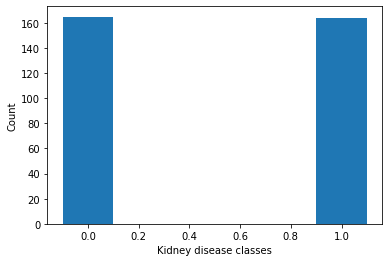

In [19]:
#get the classes distribution.
plt.hist(kidney_df[:,-1], bins =[-0.1, 0.1, 0.9, 1.1])
plt.xlabel('Kidney disease classes')
plt.ylabel('Count')
plt.show()

In [20]:
labels = ['pregnancy', 'glucose', 'blood_pressure', 'heart rate', 
              'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']

In [21]:
class0 = kidney_df[kidney_df[:,9] == 0]
class1 = kidney_df[kidney_df[:,9] == 1]

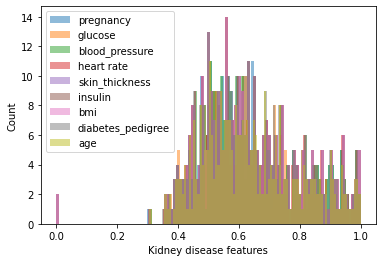

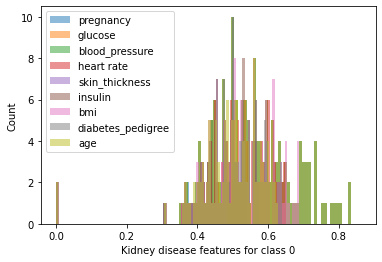

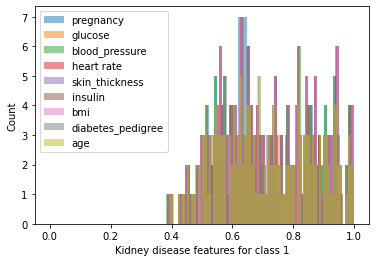

In [22]:
for i in range(len(kidney_df[0])-1):
  bins = np.linspace(min(kidney_df[i,:]), max(kidney_df[i,:]), 100)                 #100 sample for each feature divided equaly between maximum and minimum values for each feature 
  plt.hist(kidney_df[:,1], bins, alpha = 0.5, label = (labels[i]))
  plt.xlabel('Kidney disease features')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

for i in range(len(class0[0])-1):
  bins = np.linspace(min(class0[i,:]), max(class0[i,:]), 100)                 #100 sample for each feature divided equaly between maximum and minimum values for each feature 
  plt.hist(class0[:,1], bins, alpha = 0.5, label = (labels[i]))
  plt.xlabel('Kidney disease features for class 0')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

for i in range(len(class1[0])-1):
  bins = np.linspace(min(class1[i,:]), max(class1[i,:]), 100)                 #100 sample for each feature divided equaly between maximum and minimum values for each feature 
  plt.hist(class1[:,1], bins, alpha = 0.5, label = (labels[i]))
  plt.xlabel('Kidney disease features for class 1')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

In [23]:
average_of_features = np.mean(kidney_df[:,:9], axis=0)
print(average_of_features)
average_of_class_0 = np.mean(class0[:,:9], axis=0)
average_of_class_1 = np.mean(class1[:,:9], axis=0)

[0.24083674 0.63571663 0.57912657 0.21430108 0.10660218 0.48913088
 0.17781166 0.22375905 0.44021502]


average of features for all data


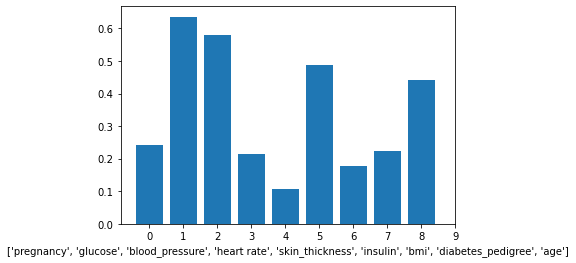

average of features for class 0 data


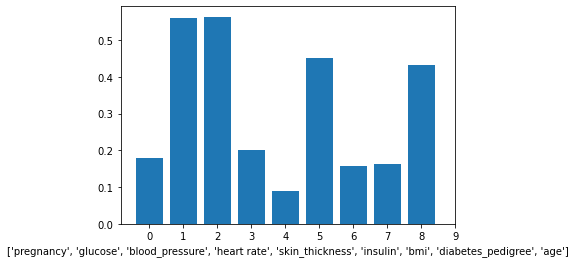

average of features for class 1 data


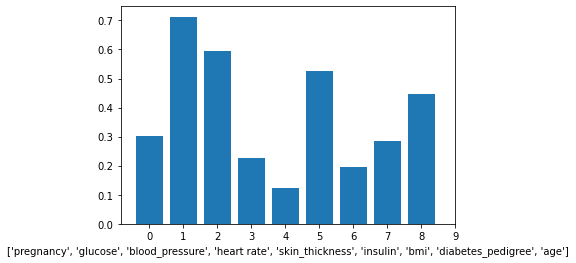

In [24]:
print("average of features for all data")
features = np.arange(0,10)
plt.bar(range(len(average_of_features)), average_of_features)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

print("average of features for class 0 data")
features = np.arange(0,10)
plt.bar(range(len(average_of_class_0)), average_of_class_0)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

print("average of features for class 1 data")
features = np.arange(0,10)
plt.bar(range(len(average_of_class_1)), average_of_class_1)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

Standard deviation for data


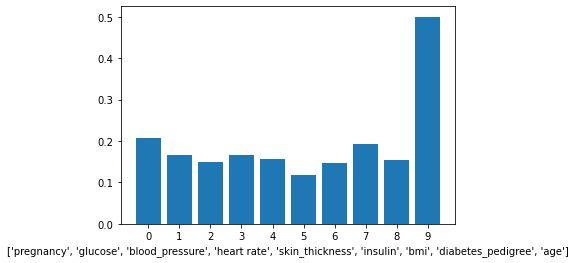

In [26]:
std = np.std(kidney_df, axis = 0)
print("Standard deviation for data")
features = np.arange(0,10)
plt.bar(range(len(std)), std)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

[0.  1.  0.5]
